# FDIC insured banks exploratory data analysis

![](fdic_hq.jpeg)

Outline:
1. Business context - although costly, failed banks do not fully explain decrease in number of banks
    * Costs of failed banks from FDIC website
    * Web scraping details of failed banks
    * API client total number of banks
2. Historical events database - Commercial vs Savings banks
    * De novo banks (*newly established institutions with no existing. operations and new institutions that result from the conversion of an operating, non-insured entity -- they can't fail during the first 5 years*)
    * Mergers, acquisitions, branch sales and conversions...
        - More than 2 banks merging into 1 entity
        - Several banks acquired by 1 bank
        - Branch sales to do change Certificate IDs
        - But conversions sometimes do change IDs
    * Voluntary liquidation, charter changes and transfers
        - check with Cullan
    * Failures, paid offs vs assistance
        - check
3. Waterfall chart as an interactive tool 
    * Commercial banks consolidation 
    * Savings banks consolidation 
    * Industry as a whole 
4. Local GUI for customized querying 
    * Inputed years outside the range
    * Example of a successful query 
    * Data download functionality 

## 1. FDIC insurance
is required for most of US credit institutions including commercial banks and savings institutions...

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1.1 Costs of failed banks
The dataset was retrieved on 10/22/2021 using download functionality. It contains information about recently (last 20 years) failed banks, i.e. name of the bank and IDs, date of restructuring and costs, as well as location of headquarters and size of assets and deposits. Source: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/

In [48]:
costs = pd.read_csv('../../data/failed_banks_cleaned.csv', index_col=0)

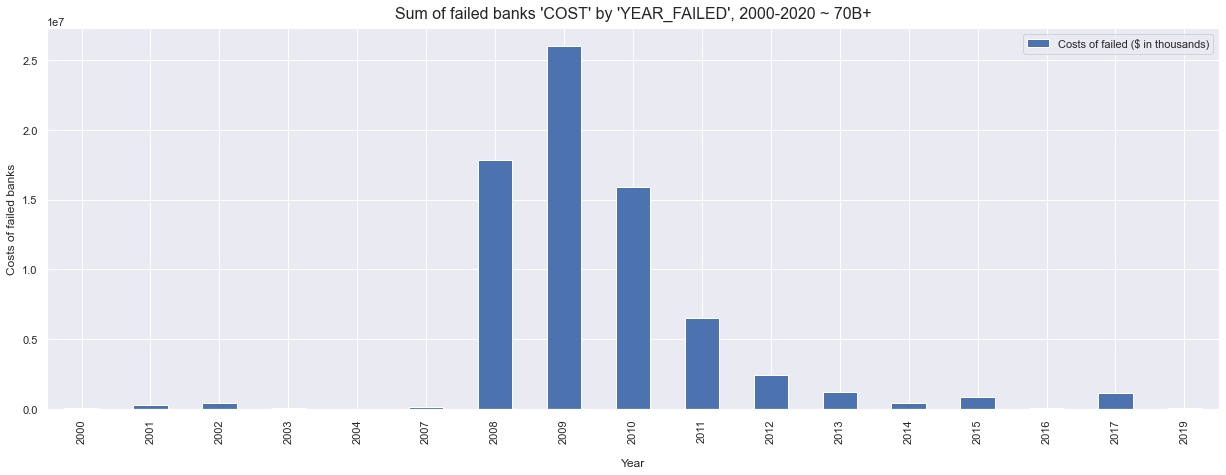

In [53]:
costs.groupby(['YEAR_FAILED'])['COST'].sum().plot(kind='bar',
                                               figsize=(21, 7),
                                               label='Costs of failed ($ in thousands)')
plt.title("Sum of failed banks 'COST' by 'YEAR_FAILED', 2000-2020 ~ 70B+", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

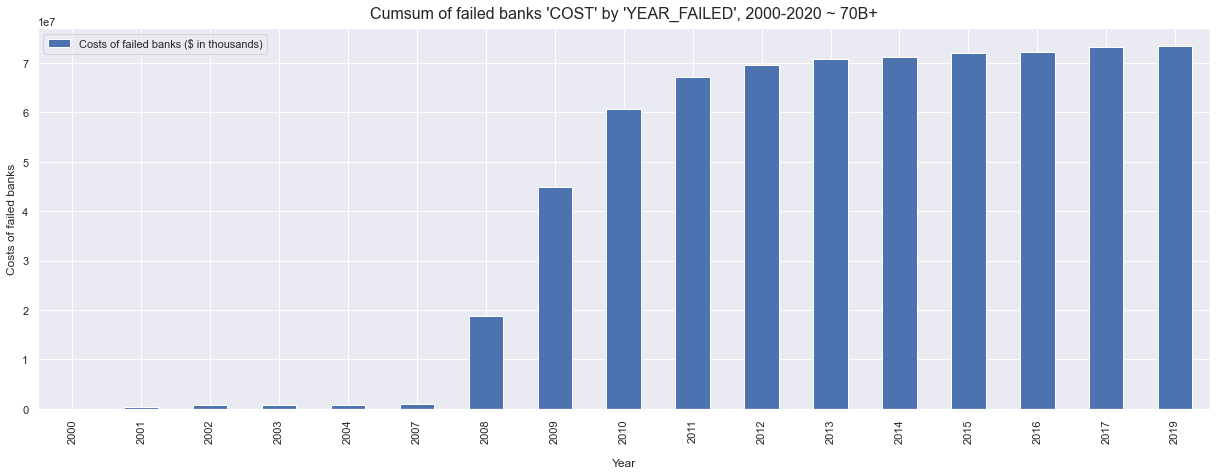

In [54]:
costs.groupby(costs['YEAR_FAILED'])['COST'].sum().cumsum(axis=0).round(2).plot(
kind='bar', figsize=(21, 7), label="Costs of failed banks ($ in thousands)")
plt.title("Cumsum of failed banks 'COST' by 'YEAR_FAILED', 2000-2020 ~ 70B+", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

### 1.2. Details of failed banks
Built a custom scraper to access some FDIC tables published on the official web site "https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/"